# Fraudulent Activities 

### OBJECTIVES

E-commerce websites are more and more used, some e-shops have to handle thousands or even millions of transactions a day. This opens room for potential fraudulent activities like money laundering or, use of stolen credit card etc. 

This Notebook aim's at computing the probability of a transaction being fraudulent thanks to Machine Learning.
 
Datasets :
```python
Fraud_Data.csv
IpAddress_to_Country.csv
```

## Import Libraries

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta
from datetime import datetime
from datetime import tzinfo
from datetime import timezone

from sklearn.utils import class_weight

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import  RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.metrics import f1_score

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [166]:
fraud_data = pd.read_csv('../data/Fraud_Data.csv')
ip_data = pd.read_csv('../data/IpAddress_to_Country.csv')

## Exploratory Analysis

In [167]:
fraud_data.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1


the class column tells us if the transaction if fraudulent '1' or regular '0'

In [168]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


As we can see there's no missing data

In [169]:
fraud_data.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


## Transform Ip to Country

The Ip Adress is not usefull as is, nevertheless we can fetch the countries where the ip come from thanks to the data in 
```python
IpAddress_to_Country.csv
```
Let's write a function to convert Ips into countries

In [170]:
ip_data.head(3)

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China


In [171]:
def transform_ip(arg) :
    try :
        return ip_data.country[(ip_data.lower_bound_ip_address < arg) & 
        (ip_data.upper_bound_ip_address > arg)].iloc[0]
        
    except IndexError :
        return "Unknown Country"

In [172]:
fraud_data['country_name'] = fraud_data['ip_address'].apply(transform_ip)

In [173]:
fraud_data.to_csv('../data/fraud_data_de.csv', index = False)

In [174]:
fraud_data = pd.read_csv('../data/fraud_data_de.csv')

In [175]:
fraud_data.head(2)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country_name
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States


## Date time

In [176]:
# We'll need to convert *signup_time* and *purchase_time* columns in datetime format
fraud_data.loc[:, 'signup_time'] =  pd.to_datetime(fraud_data.loc[:, 'signup_time'], format='%Y-%m-%d %H:%M:%S')
fraud_data.loc[:, 'purchase_time'] =  pd.to_datetime(fraud_data.loc[:, 'purchase_time'], format='%Y-%m-%d %H:%M:%S')

In [177]:
sns.set(style="ticks", palette="pastel")

## Data Viz

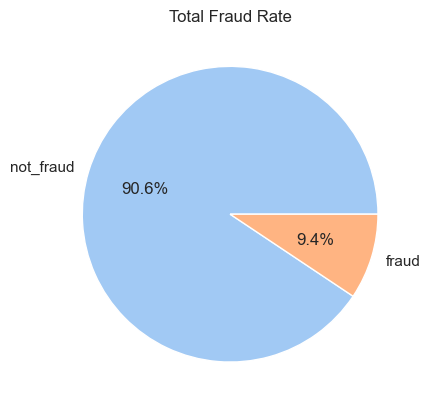

In [178]:
## fraud rate
plt.pie(fraud_data['class'].value_counts(), labels = ['not_fraud', 'fraud'], autopct='%1.1f%%')
plt.title("Total Fraud Rate")
plt.show()

C:\Users\emon1\AppData\Local\Temp\ipykernel_7092\1463402150.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot( x  = purchase_value_discretized, y = fraud_data['class'], palette='viridis')


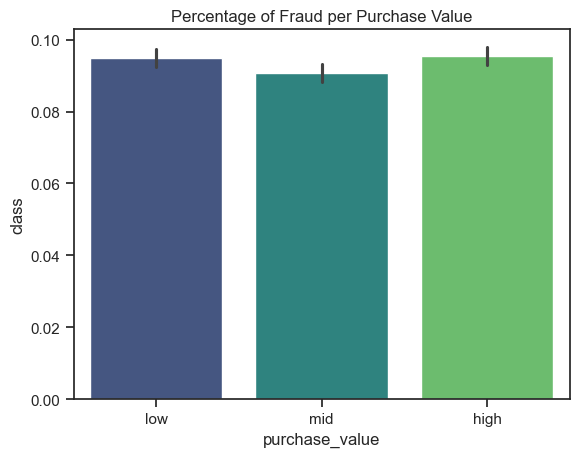

In [179]:
#  Purchase Value
purchase_value_discretized = pd.qcut(fraud_data['purchase_value'], 3, ['low','mid','high'])
sns.barplot( x  = purchase_value_discretized, y = fraud_data['class'], palette='viridis')
plt.title("Percentage of Fraud per Purchase Value")
plt.show()

C:\Users\emon1\AppData\Local\Temp\ipykernel_7092\3260993195.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = fraud_data, x  = 'source' , y = 'class', palette='inferno')


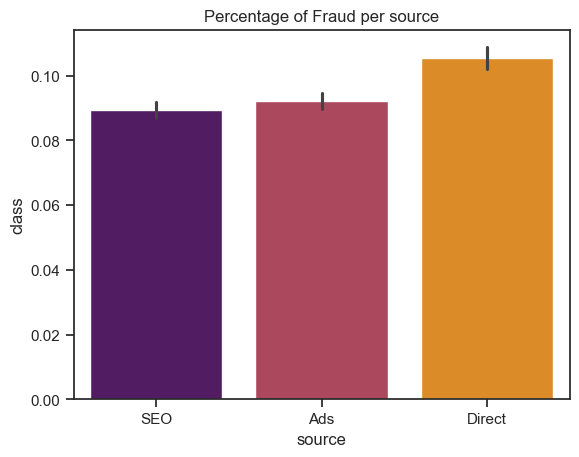

In [180]:
# source
sns.barplot(data = fraud_data, x  = 'source' , y = 'class', palette='inferno')
plt.title("Percentage of Fraud per source")
plt.show()

C:\Users\emon1\AppData\Local\Temp\ipykernel_7092\3528918153.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = fraud_data, x  = 'browser' , y = 'class', palette='magma')


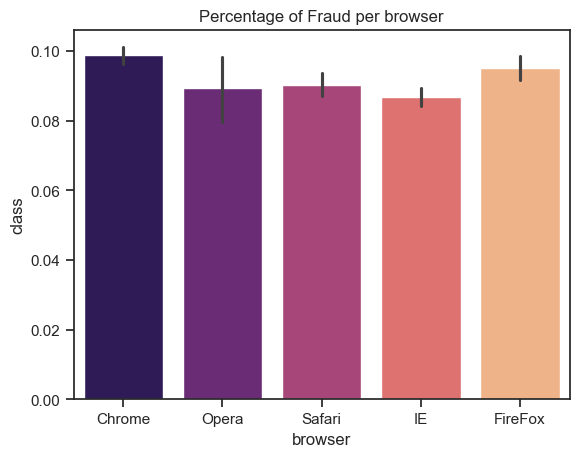

In [181]:
# browser
sns.barplot(data = fraud_data, x  = 'browser' , y = 'class', palette='magma')
plt.title("Percentage of Fraud per browser")
plt.show()

C:\Users\emon1\AppData\Local\Temp\ipykernel_7092\4027973316.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot( x  = age_discretized, y = fraud_data['class'], palette='plasma')


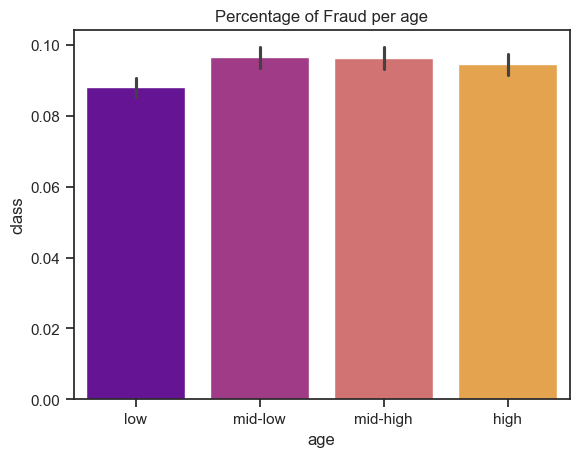

In [182]:
#  age
age_discretized = pd.qcut(fraud_data['age'], 4, ['low','mid-low', 'mid-high','high'])
sns.barplot( x  = age_discretized, y = fraud_data['class'], palette='plasma')
plt.title("Percentage of Fraud per age")
plt.show()

## Feature Engineering

In [183]:
fraud_data['country_name'].nunique()

182

In [184]:
fraud_data['country_name'].value_counts()

country_name
United States      58049
Unknown Country    21966
China              12038
Japan               7306
United Kingdom      4490
                   ...  
Myanmar                1
Vanuatu                1
Dominica               1
Niger                  1
Guadeloupe             1
Name: count, Length: 182, dtype: int64

In [185]:
fraud_data['country_name'].unique()

array(['Japan', 'United States', 'Unknown Country', 'Canada', 'China',
       'Brazil', 'India', 'Argentina', 'United Kingdom', 'South Africa',
       'Germany', 'Mexico', 'Sweden', 'Korea Republic of', 'Peru',
       'Portugal', 'Bangladesh', 'France',
       'Taiwan; Republic of China (ROC)', 'Russian Federation', 'Belgium',
       'Denmark', 'Netherlands', 'Iran (ISLAMIC Republic Of)', 'Spain',
       'Gabon', 'Saudi Arabia', 'Hong Kong', 'Georgia',
       'Syrian Arab Republic', 'Turkey', 'New Zealand', 'European Union',
       'Australia', 'Ukraine', 'Austria', 'Israel', 'Malaysia', 'Greece',
       'Italy', 'Norway', 'Poland', 'Venezuela', 'Thailand', 'Chile',
       'Morocco', 'Finland', 'Hungary', 'Indonesia', 'Colombia',
       'Ecuador', 'Lithuania', 'Switzerland', 'Viet Nam', 'Nigeria',
       'Egypt', 'Seychelles', 'Kazakhstan', 'Kenya',
       'Moldova Republic of', 'Trinidad and Tobago', 'Qatar', 'Bolivia',
       'Bulgaria', 'Romania', 'Croatia (LOCAL Name: Hrvatska)', '

In [186]:
country_fraud = fraud_data.groupby('country_name')['class'].agg({'mean','count'}).sort_values(by='mean', ascending = False)
country_fraud

,mean,count
country_name,,
Turkmenistan,1.000000,1
Namibia,0.434783,23
Sri Lanka,0.419355,31
Luxembourg,0.388889,72
Virgin Islands (U.S.),0.333333,3
...,...,...
Guadeloupe,0.000000,1
Gibraltar,0.000000,2
Ghana,0.000000,11


C:\Users\emon1\AppData\Local\Temp\ipykernel_7092\1421393752.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = data_countries, x = 'country_name', y = 'class', ax = ax, palette='rocket')


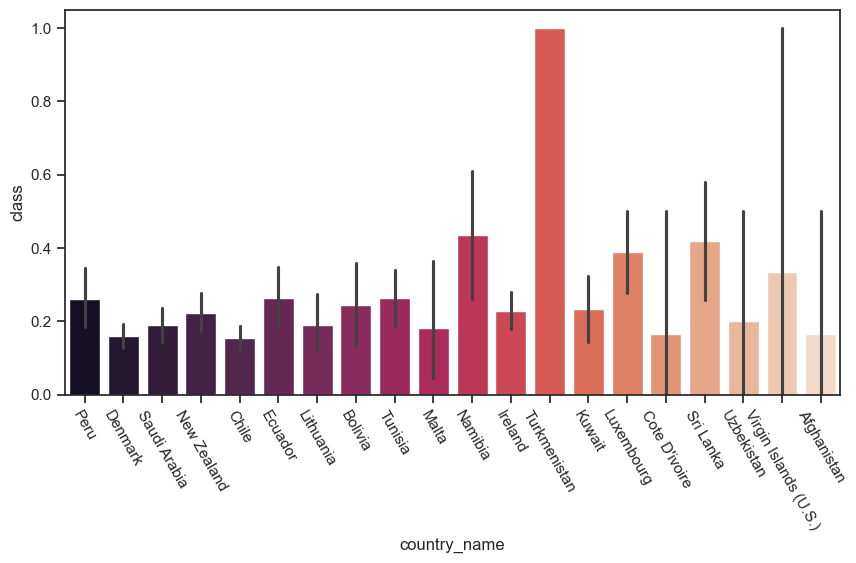

In [187]:
highest_20_countries = country_fraud.index[:20]
data_countries = fraud_data[fraud_data['country_name'].isin(highest_20_countries)]

fig, ax = plt.subplots(figsize = (10,5))
sns.barplot(data = data_countries, x = 'country_name', y = 'class', ax = ax, palette='rocket')
ax.xaxis.set_tick_params(rotation=-60)

In [188]:
# sns.catplot(fraud_data['device_id'])
#sns.histplot(data = fraud_data['ip_address'])

In [189]:
#device
df_device = fraud_data.groupby('device_id').agg({'device_id': 'count','class': np.mean})
df_device.columns = ['device_id_count', 'fraud_percentage']
df_device = df_device.sort_values(by = 'device_id_count', ascending = False)
df_device.head(15)

C:\Users\emon1\AppData\Local\Temp\ipykernel_7092\2019933898.py:2: FutureWarning: The provided callable <function mean at 0x00000264454FDBC0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_device = fraud_data.groupby('device_id').agg({'device_id': 'count','class': np.mean})


,device_id_count,fraud_percentage
device_id,,
KIPFSCNUGOLDP,20,0.950000
NGQCKIADMZORL,20,0.950000
CQTUVBYIWWWBC,20,0.950000
ITUMJCKWEYNDD,20,0.950000
EQYVNEGOFLAWK,20,0.950000
ZUSVMDEZRBDTX,20,0.950000
BWSMVSLCJXMCM,19,0.947368
IGKYVZDBEGALB,19,0.947368
EGLGSEGYPMMAM,19,0.947368


It seems that the more a device_id makes purchases the more these purchases are likely to be fraudulents
We suspect that these fraudulent purchases are made in a short window of time, probably by bots

In [190]:
fraud_data.loc[fraud_data['device_id'] == 'NGQCKIADMZORL',:].head(8)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country_name
13973,278428,2015-01-03 13:10:40,2015-01-03 13:10:41,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,1,New Zealand
17397,53591,2015-01-03 13:10:43,2015-01-03 13:10:44,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,1,New Zealand
17551,384595,2015-01-03 13:10:35,2015-01-03 13:10:36,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,1,New Zealand
19324,181018,2015-01-03 13:10:41,2015-01-03 13:10:42,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,1,New Zealand
23254,226646,2015-01-03 13:10:51,2015-01-03 13:10:52,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,1,New Zealand
23670,381483,2015-01-03 13:10:49,2015-01-03 13:10:50,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,1,New Zealand
27888,277313,2015-01-03 13:10:45,2015-01-03 13:10:46,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,1,New Zealand
62937,186785,2015-01-03 13:10:52,2015-01-03 13:10:53,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,1,New Zealand


for the device NGQCKIADMZORL we can see a purchase made almost every second 

In [191]:
device_count = fraud_data['device_id'].value_counts()
fraud_data['n_device_occur'] = fraud_data['device_id'].apply(lambda x : device_count[x] )

In [192]:
total_amount_perIP = fraud_data.groupby('ip_address')['purchase_value'].sum()
fraud_data['amount_purchase_per_ip'] = fraud_data['ip_address'].apply(lambda x: total_amount_perIP[x])
fraud_data.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country_name,n_device_occur,amount_purchase_per_ip
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,34
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,16
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,180
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown Country,1,44
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,39


In [193]:
data = fraud_data.copy()
to_remove = ['ip_address', 'device_id', 'user_id', 'purchase_value']
data = data[[c for c in data.columns if c not in to_remove  ]]

In [194]:
data.head(5)

,signup_time,purchase_time,source,browser,sex,age,class,country_name,n_device_occur,amount_purchase_per_ip
0,2015-02-24 22:55:49,2015-04-18 02:47:11,SEO,Chrome,M,39,0,Japan,1,34
1,2015-06-07 20:39:50,2015-06-08 01:38:54,Ads,Chrome,F,53,0,United States,1,16
2,2015-01-01 18:52:44,2015-01-01 18:52:45,SEO,Opera,M,53,1,United States,12,180
3,2015-04-28 21:13:25,2015-05-04 13:54:50,SEO,Safari,M,41,0,Unknown Country,1,44
4,2015-07-21 07:09:52,2015-09-09 18:40:53,Ads,Safari,M,45,0,United States,1,39


In [195]:
col_names = ['purchase_year', 'purchase_month', 'purchase_day', 'purchase_day_name' 'purchase_hour', 'purchase_min', 'purchase_sec']

In [196]:
# Convert 'signup_time' to datetime format
data['signup_time'] = pd.to_datetime(data['signup_time'], errors='coerce')

# Now you can access .dt attributes
data['signup_month'] = data['signup_time'].dt.month
data['signup_day'] = data['signup_time'].dt.day
data['signup_day_name'] = data['signup_time'].dt.day_name()

In [197]:
# Convert 'purchase_time' to datetime format
data['purchase_time'] = pd.to_datetime(data['purchase_time'], errors='coerce')

# Now you can access .dt attributes
data['purchase_month'] = data['purchase_time'].dt.month
data['purchase_day'] = data['purchase_time'].dt.day
data['purchase_day_name'] = data['purchase_time'].dt.day_name()

In [198]:

seconds_in_day = 24 * 60 * 60
to_remove = ['signup_time', 'purchase_time']

data['time_to_purchase'] = data['purchase_time'] - data['signup_time']

data['time_to_purchase'] = data['time_to_purchase'].dt.days * seconds_in_day + data['time_to_purchase'].dt.seconds

data['time_to_purchase'] = pd.qcut(data['time_to_purchase'], 10, labels = False, duplicates = 'drop')

data = data[[c for c in data.columns if c not in to_remove  ]] 

In [199]:
display(data.head(5))

,source,browser,sex,age,class,country_name,n_device_occur,amount_purchase_per_ip,signup_month,signup_day,signup_day_name,purchase_month,purchase_day,purchase_day_name,time_to_purchase
0,SEO,Chrome,M,39,0,Japan,1,34,2,24,Tuesday,4,18,Saturday,4
1,Ads,Chrome,F,53,0,United States,1,16,6,7,Sunday,6,8,Monday,0
2,SEO,Opera,M,53,1,United States,12,180,1,1,Thursday,1,1,Thursday,0
3,SEO,Safari,M,41,0,Unknown Country,1,44,4,28,Tuesday,5,4,Monday,0
4,Ads,Safari,M,45,0,United States,1,39,7,21,Tuesday,9,9,Wednesday,4


Now it might be interesting to compute the amount of purchase over the time to purchase

In [200]:
data['purchase_over_time'] = 1000* data['amount_purchase_per_ip'] / data['time_to_purchase']

In [201]:
data.head(10)

,source,browser,sex,age,class,country_name,n_device_occur,amount_purchase_per_ip,signup_month,signup_day,signup_day_name,purchase_month,purchase_day,purchase_day_name,time_to_purchase,purchase_over_time
0,SEO,Chrome,M,39,0,Japan,1,34,2,24,Tuesday,4,18,Saturday,4,8500.0
1,Ads,Chrome,F,53,0,United States,1,16,6,7,Sunday,6,8,Monday,0,inf
2,SEO,Opera,M,53,1,United States,12,180,1,1,Thursday,1,1,Thursday,0,inf
3,SEO,Safari,M,41,0,Unknown Country,1,44,4,28,Tuesday,5,4,Monday,0,inf
4,Ads,Safari,M,45,0,United States,1,39,7,21,Tuesday,9,9,Wednesday,4,9750.0
5,Ads,Chrome,M,18,0,Canada,1,42,5,21,Thursday,7,9,Thursday,4,10500.0
6,Ads,Chrome,F,19,0,Unknown Country,1,11,8,1,Saturday,8,27,Thursday,2,5500.0
7,Ads,Opera,M,34,0,United States,1,27,4,6,Monday,5,25,Monday,4,6750.0
8,SEO,IE,F,43,0,China,1,30,4,21,Tuesday,6,2,Tuesday,3,10000.0
9,Ads,IE,M,31,0,United States,1,62,1,25,Sunday,3,23,Monday,5,12400.0


## Viz Engineered Features

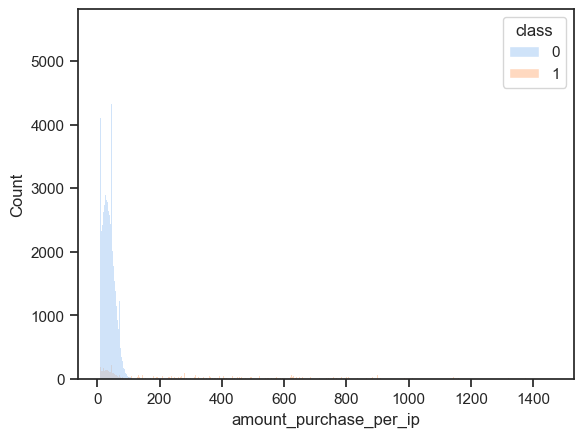

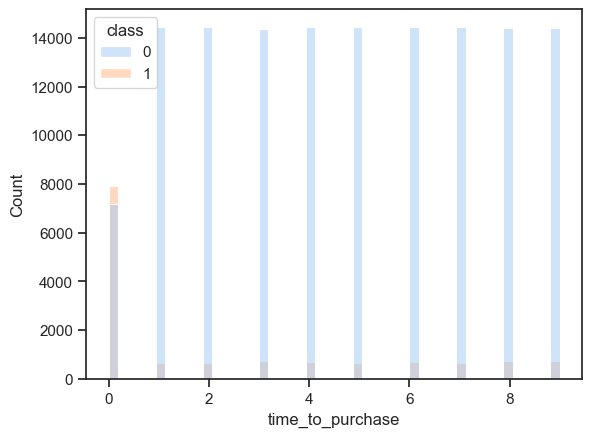

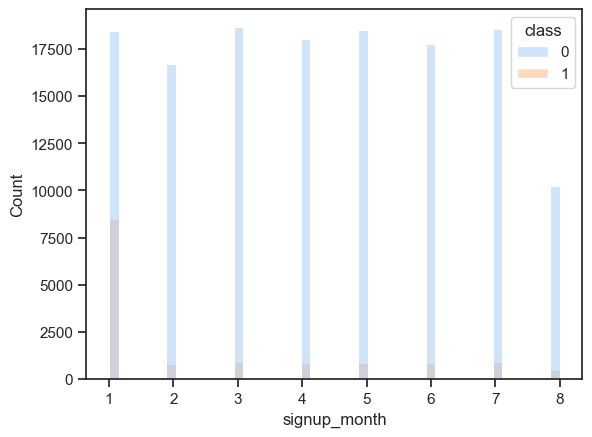

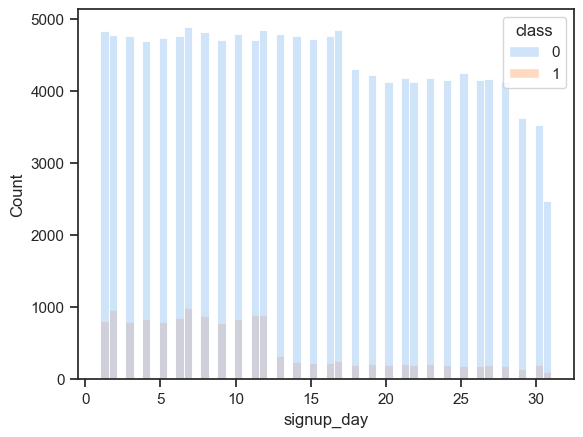

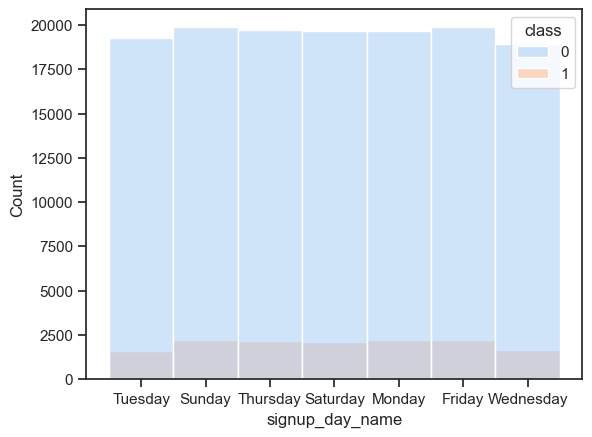

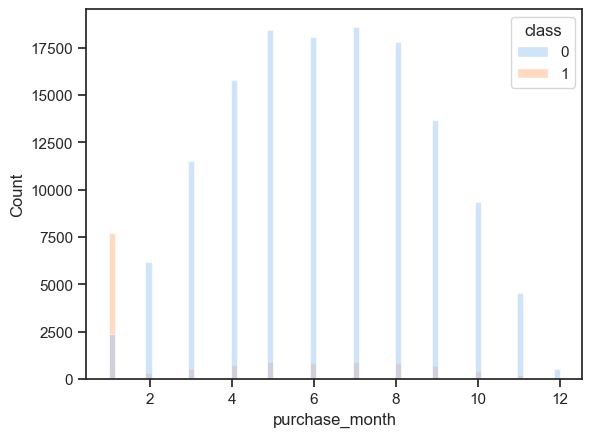

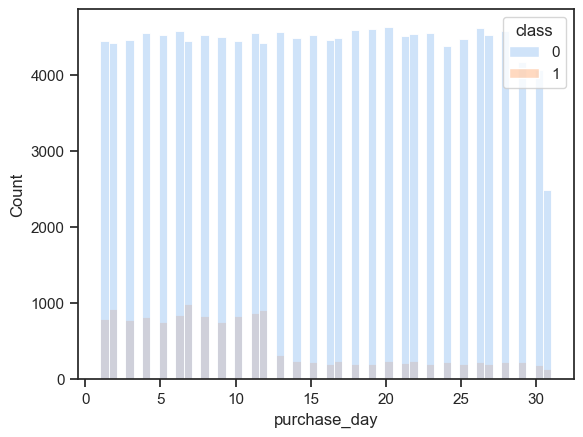

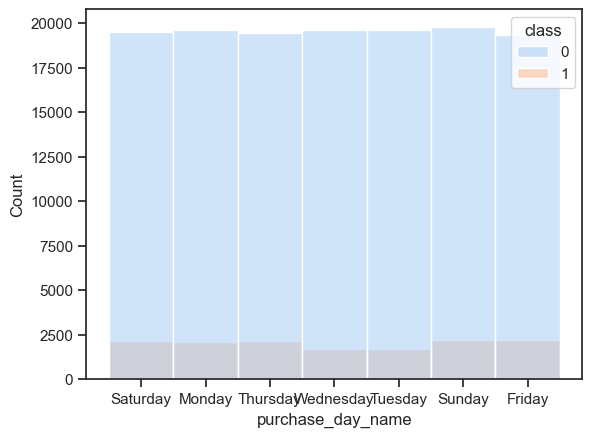

In [202]:
to_viz = ['amount_purchase_per_ip', 'time_to_purchase',	'signup_month',	'signup_day', 'signup_day_name', 'purchase_month', 'purchase_day',	'purchase_day_name']

for c in to_viz:
    plt.figure()
    sns.histplot(data = data, x = c , hue='class')
    plt.plot()

## Preprocessing

In [203]:
data

,source,browser,sex,age,class,country_name,n_device_occur,amount_purchase_per_ip,signup_month,signup_day,signup_day_name,purchase_month,purchase_day,purchase_day_name,time_to_purchase,purchase_over_time
0,SEO,Chrome,M,39,0,Japan,1,34,2,24,Tuesday,4,18,Saturday,4,8.500000e+03
1,Ads,Chrome,F,53,0,United States,1,16,6,7,Sunday,6,8,Monday,0,inf
2,SEO,Opera,M,53,1,United States,12,180,1,1,Thursday,1,1,Thursday,0,inf
3,SEO,Safari,M,41,0,Unknown Country,1,44,4,28,Tuesday,5,4,Monday,0,inf
4,Ads,Safari,M,45,0,United States,1,39,7,21,Tuesday,9,9,Wednesday,4,9.750000e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,SEO,Chrome,M,28,1,United States,2,43,1,27,Tuesday,3,29,Sunday,5,8.600000e+03
151108,SEO,Safari,M,32,0,Netherlands,1,35,5,15,Friday,5,26,Tuesday,1,3.500000e+04
151109,SEO,IE,F,26,0,Japan,1,40,3,3,Tuesday,5,20,Wednesday,6,6.666667e+03
151110,SEO,Chrome,M,37,0,United States,2,46,7,9,Thursday,9,7,Monday,5,9.200000e+03


In [204]:
to_remove = ['time_to_purchase','amount_purchase_per_ip', 'class']

x = data[[c for c in data.columns if c not in to_remove]] 
y = data['class']

x_b = x.copy()
y_b = y.copy()

x.columns

Index(['source', 'browser', 'sex', 'age', 'country_name', 'n_device_occur',
       'signup_month', 'signup_day', 'signup_day_name', 'purchase_month',
       'purchase_day', 'purchase_day_name', 'purchase_over_time'],
      dtype='object')

In [205]:
x.nunique()

source                   3
browser                  5
sex                      2
age                     58
country_name           182
n_device_occur          20
signup_month             8
signup_day              31
signup_day_name          7
purchase_month          12
purchase_day            31
purchase_day_name        7
purchase_over_time    1008
dtype: int64

In [206]:
x.dtypes

source                 object
browser                object
sex                    object
age                     int64
country_name           object
n_device_occur          int64
signup_month            int32
signup_day              int32
signup_day_name        object
purchase_month          int32
purchase_day            int32
purchase_day_name      object
purchase_over_time    float64
dtype: object

In [207]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   source              151112 non-null  object 
 1   browser             151112 non-null  object 
 2   sex                 151112 non-null  object 
 3   age                 151112 non-null  int64  
 4   country_name        151112 non-null  object 
 5   n_device_occur      151112 non-null  int64  
 6   signup_month        151112 non-null  int32  
 7   signup_day          151112 non-null  int32  
 8   signup_day_name     151112 non-null  object 
 9   purchase_month      151112 non-null  int32  
 10  purchase_day        151112 non-null  int32  
 11  purchase_day_name   151112 non-null  object 
 12  purchase_over_time  151112 non-null  float64
dtypes: float64(1), int32(4), int64(2), object(6)
memory usage: 12.7+ MB


In [208]:
x.min()

source                        Ads
browser                    Chrome
sex                             F
age                            18
country_name          Afghanistan
n_device_occur                  1
signup_month                    1
signup_day                      1
signup_day_name            Friday
purchase_month                  1
purchase_day                    1
purchase_day_name          Friday
purchase_over_time         1000.0
dtype: object

In [209]:
x.max()

source                      SEO
browser                  Safari
sex                           M
age                          76
country_name           Zimbabwe
n_device_occur               20
signup_month                  8
signup_day                   31
signup_day_name       Wednesday
purchase_month               12
purchase_day                 31
purchase_day_name     Wednesday
purchase_over_time          inf
dtype: object

In [210]:
#cat_column = [c for c in data.columns.values if data[c].dtype == 'object']
cat_column_index = [x.columns.get_loc(c) for c in x.columns if x[c].dtype == 'object']  #selecting indexes of the categorical variables
num_column_index = [x.columns.get_loc(c) for c in x.columns if x[c].dtype != 'object'] #selecting indexes of the numerical variables

In [211]:
len(cat_column_index) + len (num_column_index)

13

In [212]:
x = x.values
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state= 59, stratify = y)

In [213]:
y

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [214]:
x

array([['SEO', 'Chrome', 'M', ..., 18, 'Saturday', 8500.0],
       ['Ads', 'Chrome', 'F', ..., 8, 'Monday', inf],
       ['SEO', 'Opera', 'M', ..., 1, 'Thursday', inf],
       ...,
       ['SEO', 'IE', 'F', ..., 20, 'Wednesday', 6666.666666666667],
       ['SEO', 'Chrome', 'M', ..., 7, 'Monday', 9200.0],
       ['Direct', 'IE', 'M', ..., 21, 'Tuesday', 6666.666666666667]],
      dtype=object)

In [215]:
# Replace infinite values with NaN in DataFrames
x_train = pd.DataFrame(x_train)  # Ensure it's a DataFrame
x_test = pd.DataFrame(x_test)     # Ensure it's a DataFrame

x_train.replace([np.inf, -np.inf], np.nan, inplace=True)
x_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Optionally, fill NaN values with a specific value or strategy
x_train.fillna(0, inplace=True)
x_test.fillna(0, inplace=True)

# Create pipeline for numerical features
numerical_features = num_column_index
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_features = cat_column_index
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
)

# Combine numerical and categorical transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Fit and transform the data
x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)

print('Ready to train model')

C:\Users\emon1\AppData\Local\Temp\ipykernel_7092\811883688.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_train.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\emon1\AppData\Local\Temp\ipykernel_7092\811883688.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_test.replace([np.inf, -np.inf], np.nan, inplace=True)


Ready to train model


c:\Program Files\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Logistic Regression

In [216]:
# Train model
model = LogisticRegression()

model.fit(x_train, y_train)
print("...Done.")

...Done.


In [217]:
# Predictions on sets
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

In [218]:
from sklearn.metrics import accuracy_score
# Print scores
print("Accuracy on training set : ", accuracy_score(y_train, y_train_pred))
print("Accuracy on test set : ", accuracy_score(y_test, y_test_pred))

Accuracy on training set :  0.9539991231625706
Accuracy on test set :  0.954339410382821


In [219]:
print('f1 test :',f1_score(y_test, y_test_pred))
print('f1 train :',f1_score(y_train, y_train_pred))

f1 test : 0.689608636977058
f1 train : 0.6859434122098605


[]

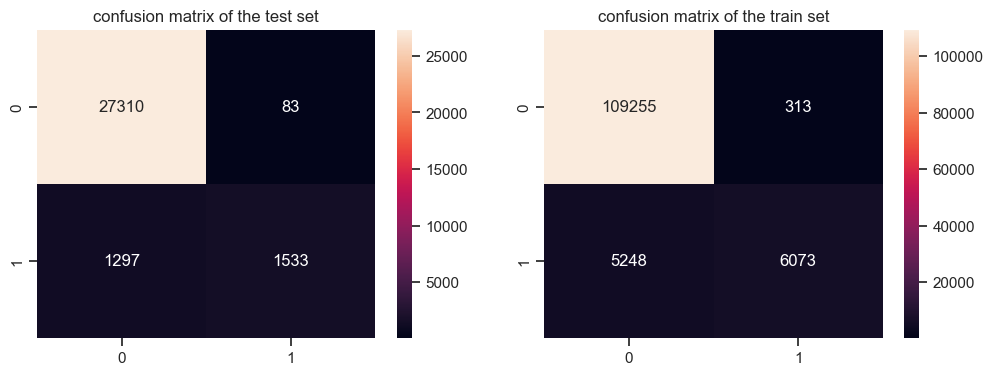

In [220]:
# Create confusion Matrix
cm_test = metrics.confusion_matrix(y_test, y_test_pred) 
cm_train = metrics.confusion_matrix(y_train, y_train_pred) 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
sns.heatmap(cm_test, annot=True, ax = ax1, fmt=".6g" )
sns.heatmap(cm_train, annot=True, ax = ax2, fmt=".6g" )

ax1.set_title('confusion matrix of the test set')
ax2.set_title('confusion matrix of the train set')
plt.plot()

In [221]:
scores_train = cross_val_score(model, x_train, y_train, cv=10, scoring='f1')
#predictions = cross_val_predict(model, X_train, Y_train, cv = 10)

print(scores_train)
print('score min :',scores_train.min())
print('score max :',scores_train.max())

[0.69966254 0.67729084 0.69360269 0.67391304 0.68161435 0.67844926
 0.70222222 0.6776204  0.69570073 0.67961165]
score min : 0.6739130434782609
score max : 0.7022222222222222


In [222]:
import pickle

pickle.dump(data,open('data.pkl','wb'))
pickle.dump(model,open('model.pkl','wb'))

<pre>
#   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   source              151112 non-null  object 
 1   browser             151112 non-null  object 
 2   sex                 151112 non-null  object 
 3   age                 151112 non-null  int64  
 4   country_name        151112 non-null  object 
 5   n_device_occur      151112 non-null  int64(1-20)
 6   signup_month        151112 non-null  int32(1-12)
 7   signup_day          151112 non-null  int32(1-32) 
 8   signup_day_name     151112 non-null  object 
 9   purchase_month      151112 non-null  int32(1-12)  
 10  purchase_day        151112 non-null  int32(1-31)
 11  purchase_day_name   151112 non-null  object 
 12  purchase_over_time  151112 non-null  float64(1000-)
</pre>

In [224]:
data['browser'].unique()

array(['Chrome', 'Opera', 'Safari', 'IE', 'FireFox'], dtype=object)